# Loading Data with Pandas

In [63]:
import pandas as pd

In [64]:
neo_corrs = pd.read_csv('NEO_correlations.csv')
neo_corrs

,construct_1,construct_2,correlation
0,Anxiety,Anxiety,1.000000
1,Friendliness,Anxiety,-0.319029
2,Imagination,Anxiety,0.061749
3,Trust,Anxiety,-0.303660
4,Self-Efficacy,Anxiety,-0.453877
...,...,...,...
895,Vulnerability,Cautiousness,-0.276091
896,Cheerfulness,Cautiousness,-0.172144
897,Liberalism,Cautiousness,-0.125071
898,Sympathy,Cautiousness,0.117780


In [65]:
neo_items =  pd.read_csv('NEO_items.csv')[['construct', 'text']]
neo_items

,construct,text
0,Achievement-Striving,Go straight for the goal.
1,Achievement-Striving,Plunge into tasks with all my heart.
2,Achievement-Striving,Demand quality.
3,Achievement-Striving,Set high standards for myself and others.
4,Achievement-Striving,Turn plans into actions.
...,...,...
295,Vulnerability,Remain calm under pressure.
296,Vulnerability,Am calm even in tense situations.
297,Vulnerability,Can handle complex problems.
298,Vulnerability,Readily overcome setbacks.


# Embedding Constructs with a Sentence Transformer

In [66]:
from sentence_transformers import SentenceTransformer

In [94]:
# Embedding items
model = SentenceTransformer('all-MiniLM-L6-v2')
neo_items['embed'] = neo_items['text'].apply(lambda x: model.encode(x))
neo_items

,construct,text,embed
0,Achievement-Striving,Go straight for the goal.,"[0.017550224, 0.0030732325, 0.008360759, -0.00..."
1,Achievement-Striving,Plunge into tasks with all my heart.,"[0.0058415597, 0.0220523, -0.00097183796, -0.0..."
2,Achievement-Striving,Demand quality.,"[0.04962262, 0.04851372, -0.008554099, 0.02624..."
3,Achievement-Striving,Set high standards for myself and others.,"[0.058788758, 0.080498435, 0.006955996, -0.013..."
4,Achievement-Striving,Turn plans into actions.,"[0.009256326, 0.059698567, -0.02826299, -0.017..."
...,...,...,...
295,Vulnerability,Remain calm under pressure.,"[0.031624105, -0.046147704, -0.015353918, -0.0..."
296,Vulnerability,Am calm even in tense situations.,"[-0.0006244038, -0.039618265, -0.009537191, 0...."
297,Vulnerability,Can handle complex problems.,"[-0.015637562, 0.03971999, -0.040296197, -0.00..."
298,Vulnerability,Readily overcome setbacks.,"[0.016926263, 0.024676101, -0.016936526, -0.04..."


In [95]:
# Averaging item embeddings to get construct embeddings
construct_embeds = neo_items[['construct', 'embed']].groupby('construct').mean()
construct_embeds = pd.DataFrame(construct_embeds['embed'].to_list(), index=construct_embeds.index)
construct_embeds

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
construct,,,,,,,,,,,,,,,,,,,,,
Achievement-Striving,0.033966,0.041198,0.002966,-0.003337,0.026796,0.011465,-0.069077,0.003882,-0.021888,0.034916,...,-0.010597,0.017478,-0.014036,0.025592,0.004061,0.009973,0.008726,-0.014676,0.039098,-0.013046
Activity-Level,0.025298,0.041397,-0.021760,0.001966,-0.004692,0.016970,-0.053101,0.004459,-0.024774,0.006384,...,0.012425,-0.001183,0.009843,0.014863,-0.012522,0.016713,0.005576,0.011766,0.022113,-0.028579
Adventurousness,0.016585,0.053207,-0.002529,-0.036604,0.004068,0.012373,-0.066900,0.012717,0.007306,0.027439,...,0.024554,-0.012120,-0.024441,-0.008162,-0.005607,0.016672,0.006765,0.044775,0.024037,-0.019029
Aesthetic Appreciation/Artistic Interests,-0.007171,0.075734,-0.008892,0.025130,0.006083,0.033804,-0.027679,0.001957,0.017058,0.030255,...,-0.018829,-0.001402,-0.026813,-0.024945,-0.016571,0.002840,-0.015549,0.035194,0.019682,-0.005116
Altruism,0.025878,0.054868,-0.000098,-0.000065,0.012929,0.023892,-0.038193,-0.014222,0.016695,0.016675,...,-0.004901,-0.000625,-0.021822,0.036997,-0.014191,-0.037097,-0.002336,-0.005746,0.048497,-0.007339
Anger,0.014552,0.009196,-0.001066,0.014499,0.003135,0.060476,-0.041818,-0.006936,0.025246,0.010562,...,0.025743,0.000003,0.017794,0.030071,-0.014305,0.039889,0.015097,-0.005728,0.024310,-0.022109
Anxiety,0.003890,0.011340,-0.013329,-0.006595,0.020876,0.038779,-0.066614,-0.004064,0.001832,0.030268,...,0.038463,-0.016765,-0.018302,0.035505,-0.018776,-0.013689,-0.000505,0.004288,0.049558,-0.027840
Assertiveness,0.034862,0.063104,-0.001723,0.009844,-0.003244,0.012172,-0.031752,-0.024959,-0.008954,0.026495,...,0.001027,0.020797,-0.003251,0.015151,0.000141,-0.005313,-0.014839,0.017292,0.042414,-0.008203
Cautiousness,0.021376,0.023080,-0.001504,-0.019681,0.011897,0.014006,-0.094714,0.009117,0.000621,0.024607,...,0.004928,0.006299,-0.033350,0.012265,0.005656,0.041724,0.019778,0.002946,0.061185,-0.023005


# Comparing Predicted and Observed Correlations

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
predicted = construct_embeds.T.corr()
predicted

construct,Achievement-Striving,Activity-Level,Adventurousness,Aesthetic Appreciation/Artistic Interests,Altruism,Anger,Anxiety,Assertiveness,Cautiousness,Cheerfulness,...,Liberalism,Modesty/Humility,Morality,Orderliness,Self-Discipline,Self-Efficacy,Self-consciousness,Sympathy,Trust,Vulnerability
construct,,,,,,,,,,,,,,,,,,,,,
Achievement-Striving,1.000000,0.591186,0.466436,0.421891,0.624278,0.533563,0.550425,0.702831,0.706608,0.500695,...,0.396046,0.598083,0.760168,0.556805,0.717027,0.747207,0.408415,0.593115,0.523718,0.617006
Activity-Level,0.591186,1.000000,0.563058,0.443930,0.549749,0.615712,0.661484,0.666243,0.729167,0.568072,...,0.289075,0.529979,0.534296,0.670576,0.693731,0.625611,0.518415,0.457542,0.442824,0.639909
Adventurousness,0.466436,0.563058,1.000000,0.553183,0.474864,0.504233,0.599109,0.477577,0.582727,0.420677,...,0.360268,0.464432,0.405460,0.613352,0.452067,0.508483,0.488534,0.438577,0.429283,0.476813
Aesthetic Appreciation/Artistic Interests,0.421891,0.443930,0.553183,1.000000,0.487302,0.493350,0.513677,0.493380,0.475544,0.553925,...,0.351386,0.494202,0.396888,0.530985,0.336698,0.462222,0.455498,0.504434,0.403380,0.437667
Altruism,0.624278,0.549749,0.474864,0.487302,1.000000,0.591238,0.635041,0.715249,0.632382,0.585059,...,0.588162,0.705596,0.728210,0.622885,0.485537,0.681022,0.598871,0.798661,0.766413,0.571677
Anger,0.533563,0.615712,0.504233,0.493350,0.591238,1.000000,0.756909,0.550268,0.619375,0.644924,...,0.369344,0.664026,0.548011,0.605091,0.476759,0.627758,0.597354,0.549238,0.485116,0.721909
Anxiety,0.550425,0.661484,0.599109,0.513677,0.635041,0.756909,1.000000,0.585003,0.684058,0.600992,...,0.360294,0.660766,0.498501,0.650913,0.554882,0.672277,0.744800,0.593418,0.613918,0.828309
Assertiveness,0.702831,0.666243,0.477577,0.493380,0.715249,0.550268,0.585003,1.000000,0.709864,0.555618,...,0.453864,0.636215,0.751482,0.580732,0.616391,0.755162,0.563984,0.612340,0.613497,0.629939
Cautiousness,0.706608,0.729167,0.582727,0.475544,0.632382,0.619375,0.684058,0.709864,1.000000,0.599347,...,0.430807,0.601655,0.705980,0.661776,0.597204,0.691753,0.515732,0.577691,0.625616,0.710088


In [104]:
# Aligning rows and columns the predicted and observed correlations
observed = neo_corrs.pivot(index='construct_1', columns='construct_2', values='correlation')
predicted, observed = predicted.align(observed)

# Mean correlation between predicted and observed
print(f'Mean r: {predicted.corrwith(observed).mean().round(2)}')
predicted, observed = predicted.abs(), observed.abs()
print(f'Mean r of absolute values: {predicted.corrwith(observed).mean().round(2)}')

Mean r: 0.56
Mean r of absolute values: 0.73


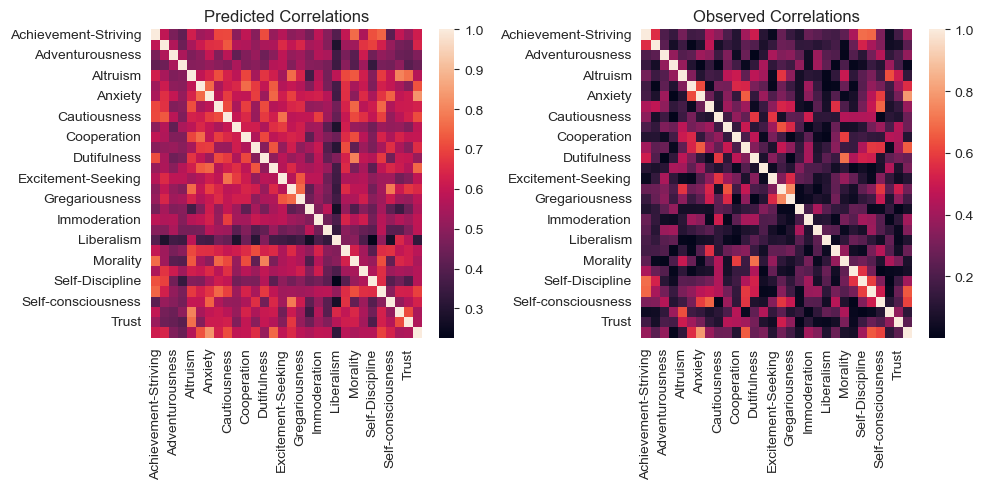

In [101]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(predicted,  ax=axs[0])
sns.heatmap(observed, ax=axs[1])
axs[0].set_title('Predicted Correlations')
axs[1].set_title('Observed Correlations')

for ax in axs:
    ax.set(xlabel='', ylabel='')

plt.tight_layout()